In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere


DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, '5000s_Loc1y2Alt_Ori2_Geo3_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

(5000, 176, 384)
(5000, 8)


In [3]:
from tqdm.notebook import tqdm

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

  0%|          | 0/5000 [00:00<?, ?it/s]

If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [4]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [5]:
import json

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
print(inference_list)
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
feature_range = (-1, 1)

normalize_labels = True

if normalize_labels:
    for i in range(labels.shape[1]):
        label = labels[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
        x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
        labels[:,i] = x_scaled
    print(labels)

['y', 'd', 'theta', 'h', 'phi', 'r_s', 'l_t', 'r_t']
[[-0.28243172 -0.54532796  0.26417643 ...  0.33010416 -0.40066101
   0.90986501]
 [ 0.00373346 -0.36648332 -0.11219416 ... -0.44178461  0.96102158
   0.3522956 ]
 [ 0.23562039  0.59473091 -0.17367867 ... -0.86911191 -0.52298181
  -0.95374107]
 ...
 [-0.95748326  0.36562874  0.12357903 ...  0.84211417 -0.05363294
   0.21249587]
 [ 0.14642616  0.25605996  0.30858309 ... -0.29179869 -0.47761528
   0.65440072]
 [ 0.10138561 -0.86443862  0.28912198 ... -0.71510536  0.48503193
   0.79542243]]


In [6]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(5000, 40)


In [8]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=8)

device = torch.device("cpu") #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:03<15:17,  3.07s/it]

Training Loss: 493.78280640393496 Validation Loss: 152.07158990204334


  4%|▎         | 11/300 [00:33<14:47,  3.07s/it]

Training Loss: 339.83198561146855 Validation Loss: 117.57191783562303


  7%|▋         | 21/300 [01:05<15:28,  3.33s/it]

Training Loss: 325.3527965322137 Validation Loss: 117.09131883829832


 10%|█         | 31/300 [01:35<13:33,  3.02s/it]

Training Loss: 313.9931891039014 Validation Loss: 124.59817473590374


 14%|█▎        | 41/300 [02:10<16:14,  3.76s/it]

Training Loss: 287.99857709929347 Validation Loss: 118.87399642169476


 17%|█▋        | 51/300 [02:46<15:00,  3.62s/it]

Training Loss: 248.1579733788967 Validation Loss: 99.40374791994691


 20%|██        | 61/300 [03:23<14:27,  3.63s/it]

Training Loss: 221.51863724645227 Validation Loss: 95.97448242083192


 24%|██▎       | 71/300 [03:59<13:52,  3.64s/it]

Training Loss: 203.6010807864368 Validation Loss: 95.28932149335742


 27%|██▋       | 81/300 [04:35<13:16,  3.64s/it]

Training Loss: 190.69603830762208 Validation Loss: 93.74051998369396


 30%|███       | 91/300 [05:12<12:40,  3.64s/it]

Training Loss: 181.66244296729565 Validation Loss: 92.32882366329432


 34%|███▎      | 101/300 [05:48<12:03,  3.63s/it]

Training Loss: 172.57836583070457 Validation Loss: 94.57711174152792


 37%|███▋      | 111/300 [06:24<11:25,  3.63s/it]

Training Loss: 165.08849208801985 Validation Loss: 95.32831658236682


 40%|████      | 121/300 [07:01<10:49,  3.63s/it]

Training Loss: 161.64042673725635 Validation Loss: 96.05959295108914


 44%|████▎     | 131/300 [07:37<10:12,  3.62s/it]

Training Loss: 155.47731913812459 Validation Loss: 93.99815835058689


 47%|████▋     | 141/300 [08:13<09:36,  3.63s/it]

Training Loss: 149.63679371587932 Validation Loss: 98.31963284127414


 50%|█████     | 151/300 [08:49<08:59,  3.62s/it]

Training Loss: 144.05389625858516 Validation Loss: 96.90787822753191


 54%|█████▎    | 161/300 [09:25<08:23,  3.62s/it]

Training Loss: 142.03825497534126 Validation Loss: 98.24951703287661


 57%|█████▋    | 171/300 [10:02<07:47,  3.62s/it]

Training Loss: 136.9552348246798 Validation Loss: 100.07264092192054


 60%|██████    | 181/300 [10:38<07:11,  3.62s/it]

Training Loss: 133.28599653858691 Validation Loss: 99.78094321768731


 64%|██████▎   | 191/300 [11:14<06:34,  3.62s/it]

Training Loss: 130.9008293664083 Validation Loss: 101.22797579318285


 67%|██████▋   | 201/300 [11:50<05:58,  3.62s/it]

Training Loss: 127.59803843917325 Validation Loss: 101.98573792167008


 70%|███████   | 211/300 [12:27<05:22,  3.62s/it]

Training Loss: 124.61944305896759 Validation Loss: 103.0106167178601


 74%|███████▎  | 221/300 [13:03<04:46,  3.63s/it]

Training Loss: 122.35625647101551 Validation Loss: 103.81220130994916


 77%|███████▋  | 231/300 [13:39<04:10,  3.62s/it]

Training Loss: 120.92538237478584 Validation Loss: 103.21553475037217


 80%|████████  | 241/300 [14:15<03:33,  3.62s/it]

Training Loss: 119.19466742873192 Validation Loss: 104.76378415711224


 84%|████████▎ | 251/300 [14:52<02:57,  3.62s/it]

Training Loss: 117.17593406373635 Validation Loss: 107.74020978994668


 87%|████████▋ | 261/300 [15:28<02:21,  3.62s/it]

Training Loss: 115.97001906344667 Validation Loss: 108.90067847073078


 90%|█████████ | 271/300 [16:04<01:45,  3.62s/it]

Training Loss: 115.09067381406203 Validation Loss: 109.40038907900453


 94%|█████████▎| 281/300 [16:40<01:08,  3.62s/it]

Training Loss: 113.84353364724666 Validation Loss: 111.24586057662964


 97%|█████████▋| 291/300 [17:16<00:32,  3.62s/it]

Training Loss: 113.41110838856548 Validation Loss: 113.04684608988464


100%|██████████| 300/300 [17:49<00:00,  3.57s/it]


In [9]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: 0.4141127915660744
(128, 8)
(128, 8)


In [10]:
if normalize_labels:
    for i in range(y.shape[1]):
        old_y = y[:,i]
        old_out = output[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_y = (((old_y - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        
        org_out = (((old_out - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        y[:,i] = org_y
        output[:,i] = org_out

<IPython.core.display.Javascript object>


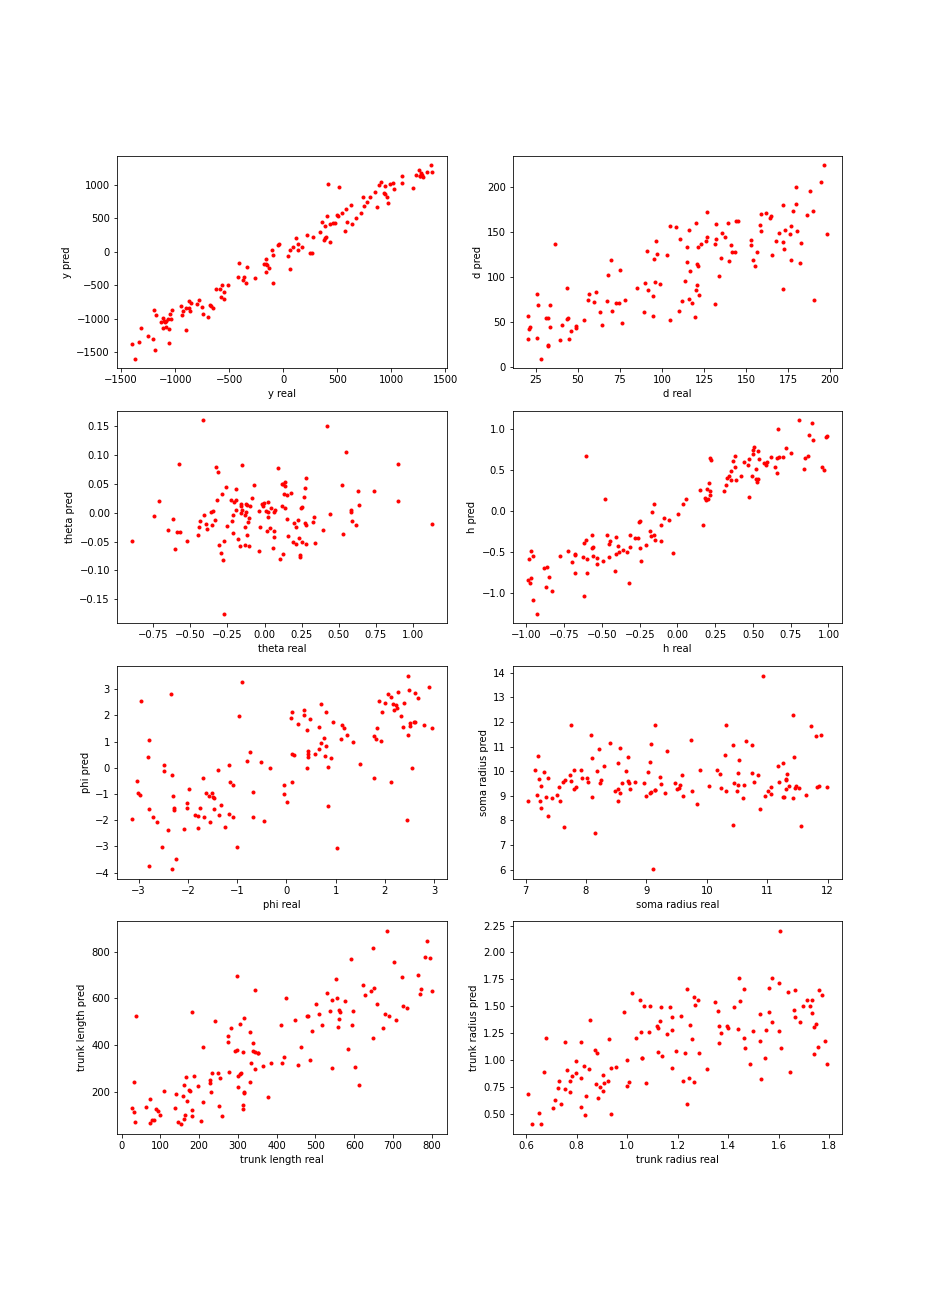

In [12]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(13, 18))

ax_y = plt.subplot(421)
ax_y.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_y.set_xlabel('y real')
ax_y.set_ylabel('y pred')

ax_d = plt.subplot(422)
ax_d.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')

ax_t = plt.subplot(423)
ax_t.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')

ax_h = plt.subplot(424)
ax_h.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(425)
ax_p.scatter(y[:,4], output[:,4], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

ax_lt = plt.subplot(426)
ax_lt.scatter(y[:,5], output[:,5], c='red', marker='.')
ax_lt.set_xlabel('soma radius real')
ax_lt.set_ylabel('soma radius pred')

ax_lt = plt.subplot(427)
ax_lt.scatter(y[:,6], output[:,6], c='red', marker='.')
ax_lt.set_xlabel('trunk length real')
ax_lt.set_ylabel('trunk length pred')

ax_lt = plt.subplot(428)
ax_lt.scatter(y[:,7], output[:,7], c='red', marker='.')
ax_lt.set_xlabel('trunk radius real')
ax_lt.set_ylabel('trunk radius pred')


plt.show()

In [13]:
DATA_PATH = 'cell_inference/resources/invivo'

INVIVO_PATH = os.path.join(DATA_PATH, 'cell377LFP2D.h5')

with h5py.File(INVIVO_PATH, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    print(f['coord'][:].shape)
    print(f['data'][:].shape)
    a_group_key = list(f.keys())[0]

    # Get the data
    test_data = f['data'][:]

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'cell_inference/resources/invivo/cell377LFP2D.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
np.set_printoptions(suppress=True)

print(params.ELECTRODE_POSITION[:, :2].shape)
print(test_data[i, :].shape)

# g_lfp, _ = build_lfp_grid(test_data, params.ELECTRODE_POSITION)
summ_stats = np.array(calculate_stats(test_data))
print(summ_stats.shape)

model1.eval()
summ_stats = torch.Tensor(np.expand_dims(summ_stats, axis=0))
print(summ_stats.shape)
summ_stats_tensor = summ_stats.to(device)
pred = model1(summ_stats_tensor)
pred = pred.to("cpu").detach().numpy()

if normalize_labels:
    for i in range(pred.shape[1]):
        old_pred = pred[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_pred = (((old_pred - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        pred[:,i] = org_pred
print(pred)

In [ ]:
%matplotlib inline

cell_idx = 0

t = np.arange(test_data.shape[0])
print(test_data.shape)

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(params.ELECTRODE_POSITION[:,0])
e_idx = ((params.ELECTRODE_POSITION[:,0]==x_dist[ix]) & 
         (params.ELECTRODE_POSITION[:,1]>=ylim[0]) & 
         (params.ELECTRODE_POSITION[:,1]<=ylim[1]))

print(e_idx.shape)
print(params.ELECTRODE_POSITION[e_idx, 1].shape)
print(t.shape)

_ = plot_lfp_heatmap(t,
                     params.ELECTRODE_POSITION[e_idx, 1],
                     test_data[:,e_idx], vlim='auto',
                     fontsize=15,labelpad=0,ticksize=10,nbins=5)